# Demonstration of window-level seismic event recognition using Semantic Segmentation Models

## Import Dependencies

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import tensor, cuda
import pandas as pd

### Add utils to sys to import our custom scripts
**Note:** This notebook should be run from the `examples` folder to ensure the correct imports and file paths are used.

In [2]:
# Go up one level from 'examples' and point to 'utils' folder
utils_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'utils'))
# Add the 'utils' folder to sys.path
sys.path.append(utils_path)
models_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'models'))
# Add the 'models' folder to sys.path
sys.path.append(models_path)
import data_utils
import model_utils

d:\Camilo\Volcanes_UFRO\PAPER IEEE\repo\.repo_venv\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### Load the model

Model can be loaded through the model_selector() function. Available architectures are: "UNet", "UNetPlusPlus", "DeepLabV3", "SwinUNet", and PhaseNet. If you wish to load the weights generated by the article, you can set the pretrained argument to True, it automatically downloads the weights from [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15098817.svg)](https://doi.org/10.5281/zenodo.15098817) (weights are only available for input size N=256). Number of parameters for each model at each input size evaluated in the article is shown below:

In [3]:
architectures = ["UNet", "UNetPlusPlus", "DeepLabV3", "SwinUNet", "PhaseNet"]
parameters = []
for arch in architectures:
    for N in [64, 128, 256]:
        device = "cuda" if cuda.is_available() == True else "cpu"
        model = model_utils.model_selector(arch=arch, N=N, pretrained=False).to(device)
        parameters.append([arch, N, np.round(model_utils.return_trainable_parameters(model)/1000000,2)])
del model
parameters = pd.DataFrame(parameters,columns=["arch", "N", "Million parameters"])

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:6
---final upsample expand_first---
SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:6
---final upsample expand_first---


d:\Camilo\Volcanes_UFRO\PAPER IEEE\repo\.repo_venv\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:6
---final upsample expand_first---


In [4]:
parameters.head(15)

,arch,N,Million parameters
0,UNet,64,7.78
1,UNet,128,7.78
2,UNet,256,7.78
3,UNetPlusPlus,64,6.67
4,UNetPlusPlus,128,6.67
5,UNetPlusPlus,256,6.67
6,DeepLabV3,64,3.20
7,DeepLabV3,128,3.20
8,DeepLabV3,256,3.20
9,SwinUNet,64,6.81


In [5]:
device = "cuda" if cuda.is_available() == True else "cpu"
model = model_utils.model_selector(arch='UNet', N=256, pretrained=True).to(device)

UNet.pt Already downloaded
Loading weights...
Succesfuly loaded weights


### Load and display example Data

In [6]:
NVCh_data = ["../data/NVCh_VT_1.npy",
            "../data/NVCh_VT_2.npy",
            "../data/NVCh_LP_1.npy",
            "../data/NVCh_LP_2.npy",
            "../data/NVCh_TR_1.npy",
            "../data/NVCh_TR_2.npy",
            "../data/NVCh_AV_1.npy",
            "../data/NVCh_AV_2.npy",
            "../data/NVCh_IC_1.npy",
            "../data/NVCh_IC_2.npy",
            "../data/CAU_VT_1.npy",
            "../data/CAU_VT_2.npy",
            "../data/CAU_LP_1.npy",
            "../data/CAU_LP_2.npy",
            "../data/CAU_TR_1.npy",
            "../data/CAU_TR_2.npy",
            "../data/LDM_VT_1.npy",
            "../data/LDM_VT_2.npy",
            "../data/VCA_VT_1.npy",
            "../data/VCA_VT_2.npy"]

Select data to test

In [7]:
idx = 0

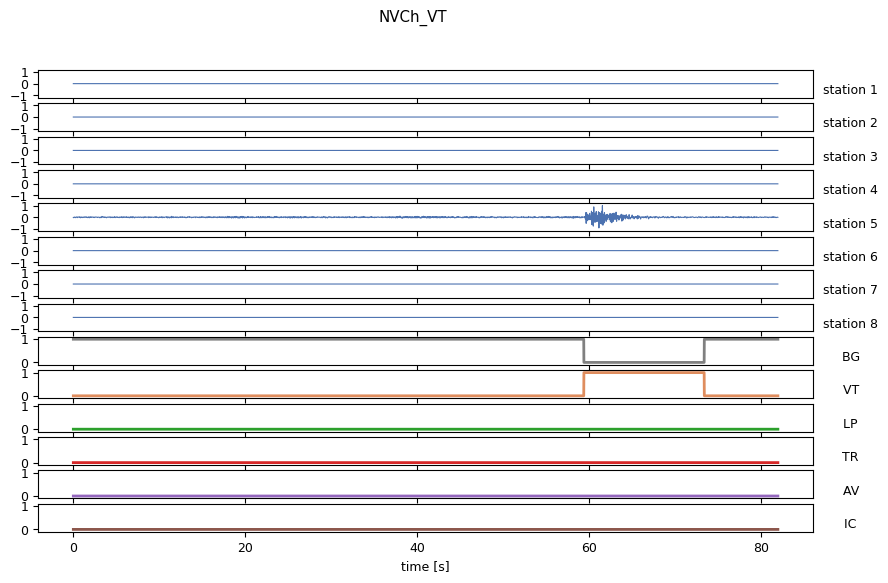

In [8]:
example_trace = np.load(NVCh_data[idx])
data_utils.plot_trace(example_trace,
                        n_stations=8,
                        save_path=None,
                        save=False,
                        title=NVCh_data[idx][8:-6],
                        num=0,
                        dpi=100,
                        figsize=(10, 6),
                        font_size=9)

...and the desired outputs:

(6, 8192)


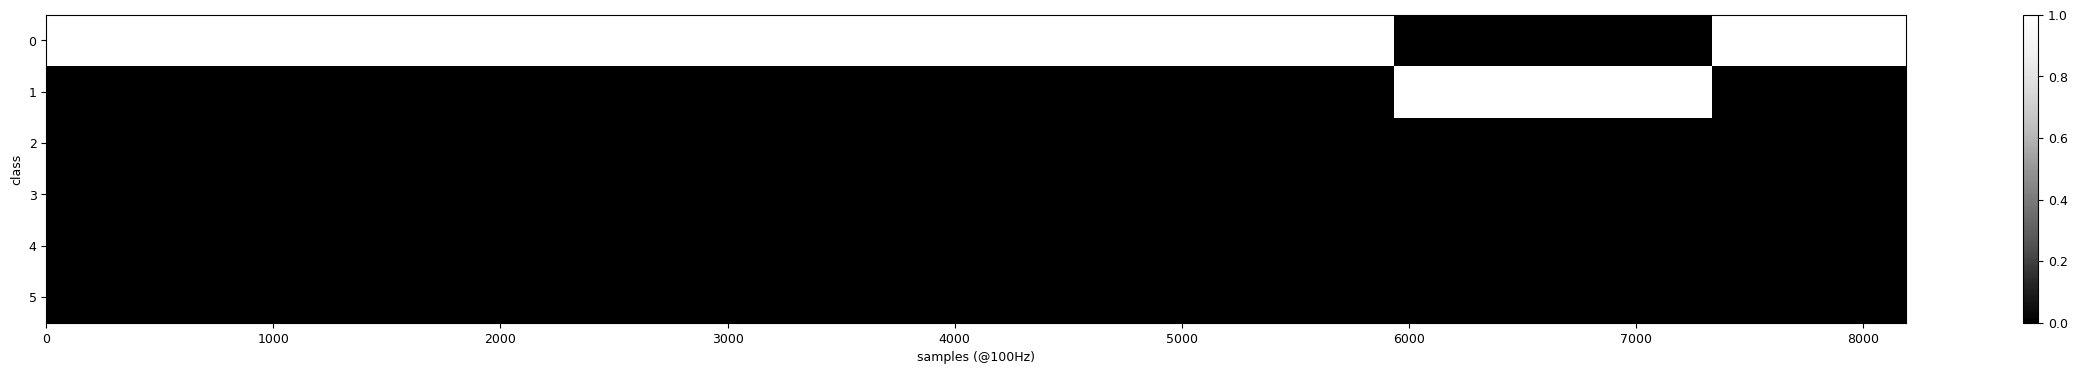

In [9]:
desired_output = example_trace[8:,:]
print(desired_output.shape)
plt.figure(figsize=(30,4))
plt.imshow(desired_output,aspect="auto", cmap="Greys_r", interpolation="nearest")
plt.xlabel("samples (@100Hz)")
plt.ylabel("class")
plt.colorbar()
plt.show()

### Prepare Input:
To pass it through the model, we Stack the 8-channel 1D array to form a 256x256 image:

(8, 8192)
torch.Size([1, 1, 256, 256])


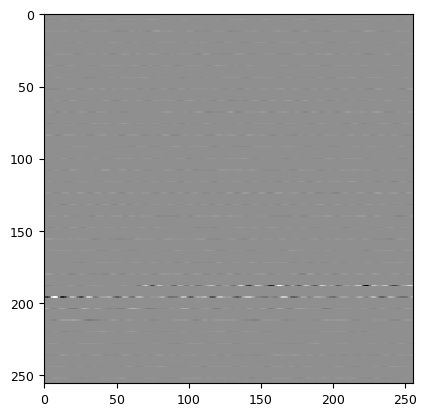

In [12]:
input_signal = example_trace[:8,:]
print(input_signal.shape)
input_tensor = tensor(input_signal)
stacked_input = data_utils.patch_stacking_X(input_tensor.unsqueeze(0), N=256)
print(stacked_input.shape)
plt.imshow(stacked_input[0][0].numpy(), cmap='Greys_r', interpolation='nearest')
plt.show()

Pass the input through the model to obtain 6 predicted 2D masks:

In [14]:
batched_stacked_input = stacked_input.to(device)
print("Input shape:",batched_stacked_input.shape)
output = model(batched_stacked_input)
print("Output shape:",output.shape)

Input shape: torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 6, 256, 256])


### We can visualize the desired and predicted masks:

Desired:

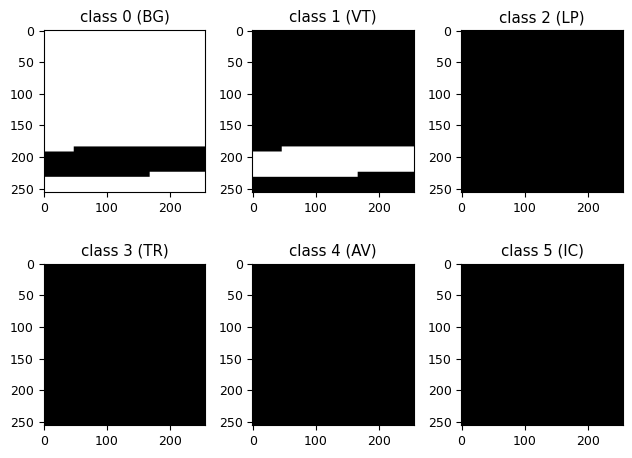

In [15]:
stacked_targets = data_utils.patch_stacking_y(tensor(desired_output)).numpy()
fig,axes = plt.subplots(2,3)
axes[0,0].imshow(stacked_targets[0],cmap='Greys_r')
axes[0,0].set_title('class 0 (BG)')
axes[0,1].imshow(stacked_targets[1],cmap='Greys_r')
axes[0,1].set_title('class 1 (VT)')
axes[0,2].imshow(stacked_targets[2],cmap='Greys_r')
axes[0,2].set_title('class 2 (LP)')
axes[1,0].imshow(stacked_targets[3],cmap='Greys_r')
axes[1,0].set_title('class 3 (TR)')
axes[1,1].imshow(stacked_targets[4],cmap='Greys_r')
axes[1,1].set_title('class 4 (AV)')
axes[1,2].imshow(stacked_targets[5],cmap='Greys_r')
axes[1,2].set_title('class 5 (IC)')
plt.tight_layout()
plt.show()

Predicted:

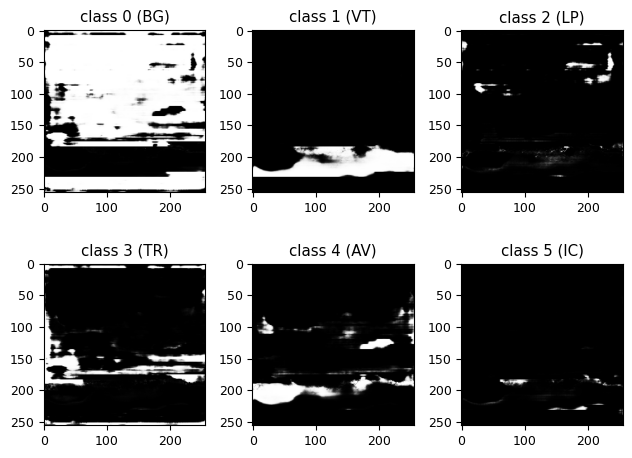

In [16]:
detached_output = output.detach().cpu().numpy()[0]
fig,axes = plt.subplots(2,3)
axes[0,0].imshow(detached_output[0],cmap='Greys_r')
axes[0,0].set_title('class 0 (BG)')
axes[0,1].imshow(detached_output[1],cmap='Greys_r')
axes[0,1].set_title('class 1 (VT)')
axes[0,2].imshow(detached_output[2],cmap='Greys_r')
axes[0,2].set_title('class 2 (LP)')
axes[1,0].imshow(detached_output[3],cmap='Greys_r')
axes[1,0].set_title('class 3 (TR)')
axes[1,1].imshow(detached_output[4],cmap='Greys_r')
axes[1,1].set_title('class 4 (AV)')
axes[1,2].imshow(detached_output[5],cmap='Greys_r')
axes[1,2].set_title('class 5 (IC)')
plt.tight_layout()
plt.show()

To obtain the time segmentation we must unstack and binarize the activations for each class:

In [17]:
unstacked_activations = data_utils.activation_unstacking(output)[0].detach().cpu().numpy()
max_indices = np.argmax(unstacked_activations, axis=0)
binarized_activations = np.eye(len(unstacked_activations))[max_indices].T


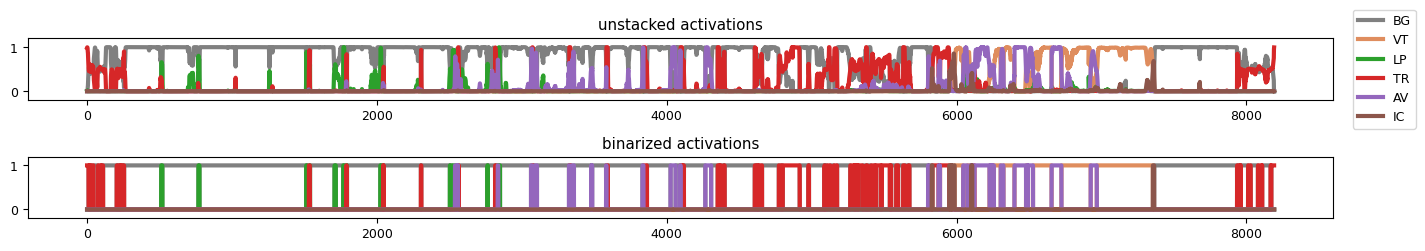

In [18]:
colors = {
    0: "#808080",
    1: "#df8d5e",
    2: "#2ca02c",
    3: "#d62728",
    4: "#9467bd",
    5: "#8c564b",
}
class_label = {
    0: "BG",
    1: "VT",
    2: "LP",
    3: "TR",
    4: "AV",
    5: "IC",
}
fig, axes = plt.subplots(2,1,figsize=(17,2.5))
for i in range(6):
    axes[0].plot(unstacked_activations[i],color=colors[i],label=class_label[i],lw=3)
    axes[1].plot(binarized_activations[i],color=colors[i],label=class_label[i],lw=3)
axes[0].set_ylim(-0.2,1.2)
axes[1].set_ylim(-0.2,1.2)
axes[0].set_title("unstacked activations")
axes[1].set_title("binarized activations")
axes[0].legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust right margin to make space for legend

After unstacking and binarizing, we can find start and end times for the detected events. We can obtain a proxy for classification confidence by summing the non-binarized activations. In the following script we record model confidence for the first and second most probable class assignments:

In [28]:
indices_start_, indices_end_ = data_utils.get_events(binarized_activations[0])

label_map = {1: "VT", 2: "LP", 3: "TR", 4: "AV", 5: "IC"}
events = []

for idx_start_,idx_end_ in zip(indices_start_,indices_end_):
    class_act = unstacked_activations[1:,idx_start_:idx_end_].sum(axis=1)
    if idx_end_-idx_start_>50:
        class_act = (class_act/class_act.sum())*100
        idx_desc = np.argsort(-class_act)+1      # or: arr.argsort()[::-1]
        pred_label = label_map[idx_desc[0]]
        second_pred_label = label_map[idx_desc[1]]
        conf_1 = class_act[idx_desc[0]-1]
        conf_2 = class_act[idx_desc[1]-1]
        events.append([pred_label, idx_start_, idx_end_,second_pred_label, np.round(conf_1,1),np.round(conf_2,1)])

cols = ["pred_label", "idx_start", "idx_end", "second_pred_label", "conf_1", "conf_2"]
predicted_df = pd.DataFrame(events, columns=cols)
predicted_df['duration']=predicted_df['idx_end']-predicted_df['idx_start']
print(len(predicted_df))
predicted_df = predicted_df.round(2)
predicted_df.head(len(predicted_df))

3


,pred_label,idx_start,idx_end,second_pred_label,conf_1,conf_2,duration
0,TR,4801,4918,AV,99.599998,0.200000,117
1,TR,5485,5540,AV,86.099998,11.200000,55
2,VT,5829,7364,AV,58.400002,27.700001,1535


Detected events are then post-processed by merging same-class events separated by less than 2.5 seconds and discarding detections that do not fall into the limits estimated from the 24,493 labeled windows:

VT: 6–90 s, LP: 10–80 s, TR: $\ge$ 55 s, AV: 11–100 s, and IC: 3–16 s.

In [29]:
merged_detections = data_utils.merge_same_class_events_with_gap(
    predicted_df
)
merged_detections = merged_detections.round(2)
merged_detections.head(len(merged_detections))

,idx_start,idx_end,pred_label,second_pred_label,conf_1,conf_2
0,4801,4918,TR,AV,99.6,0.2
1,5485,5540,TR,AV,86.1,5.6
2,5829,7364,VT,AV,58.4,27.7


In [30]:
bounds = {
    "VT": (600,   9000),
    "LP": (1000,  8000),
    "TR": (5500,  9999999),
    "AV": (1100,  10000),
    "IC": (300,   1600),
}

merged_detections["duration"] = (
    merged_detections["idx_end"] - merged_detections["idx_start"]
)

bounds_df = (
    pd.DataFrame(bounds, index=["min_dur", "max_dur"])
    .T.reset_index()
    .rename(columns={"index": "pred_label"})
)
filtered_detections = (
    merged_detections.merge(bounds_df, on="pred_label", how="inner")
    .query("min_dur <= duration <= max_dur")
    .drop(columns=["min_dur", "max_dur"])
    .reset_index(drop=True)
)
# filtered_detections = filtered_detections.round(2)
filtered_detections.head(len(filtered_detections))

,idx_start,idx_end,pred_label,second_pred_label,conf_1,conf_2,duration
0,5829,7364,VT,AV,58.4,27.7,1535


Resulting predictions are displayed through the *plot_window_with_act_onehot_and_uncertainty()* function. Note that reference is shown as a darker colored rectangle below the signal and detected events are shown as a lighter colored rectangle on top of it. Although detection is the same accross all stations we plot them at each one for ease of visualization.

In [31]:
# snippet to use the plot function:
input_trace = np.concat([np.zeros(example_trace[:8,:].shape[1]).reshape(1,-1),example_trace[:8,:]],axis=0)
label_map = {1: "VT", 2: "LP", 3: "TR", 4: "AV", 5: "IC"}
event_rows = example_trace[9:14]
events = []
for i, row in enumerate(event_rows, start=1):
    is_event = row == 1
    diff = np.diff(is_event.astype(int))
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1
    # Handle event that starts at 0
    if is_event[0]:
        starts = np.insert(starts, 0, 0)
    # Handle event that ends at last index
    if is_event[-1]:
        ends = np.append(ends, len(row))

    for s, e in zip(starts, ends):
        events.append({"idx_start": s, "idx_end": e, "event_type": label_map[i]})

reference = pd.DataFrame(events, columns=["idx_start", "idx_end", "event_type"])

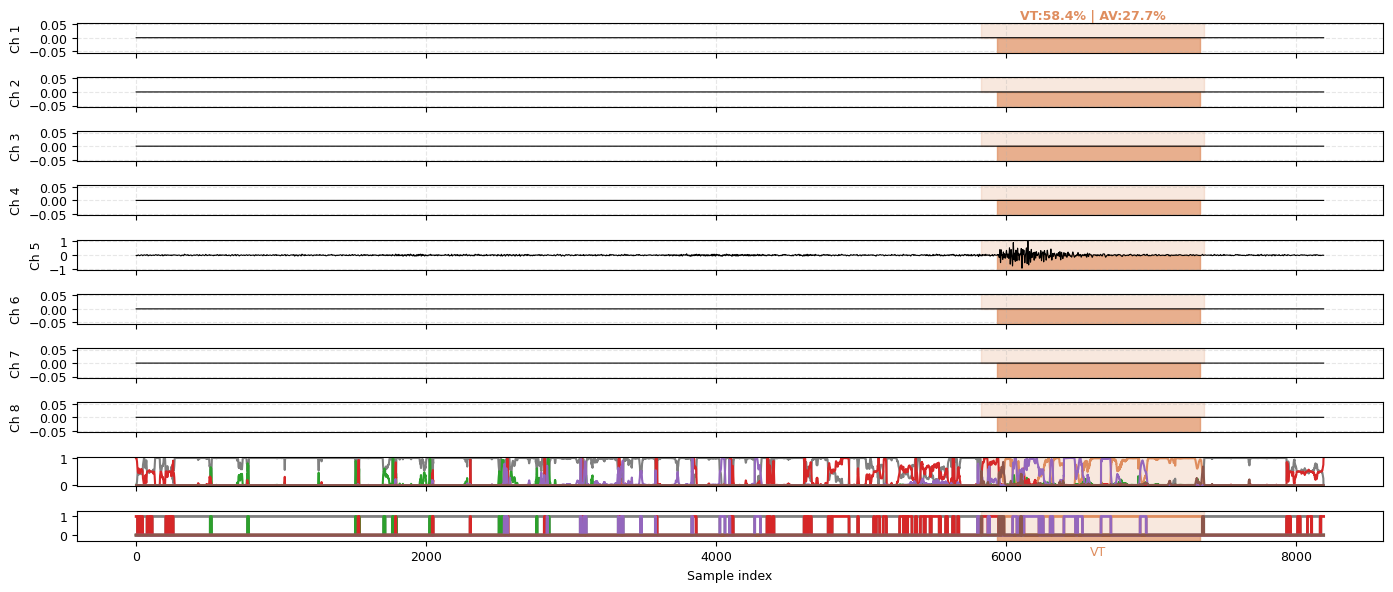

In [32]:
%matplotlib inline
plt.ion()
data_utils.plot_window_with_act_onehot_and_uncertainty(
    input_trace, reference, filtered_detections, unstacked_activations, binarized_activations, 0, window_size=8192, figsize=(14,6)
)